### Imports

Make sure all the correct packages etc are installed.

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
from utilities.image_methods.image_enhancing import ImageEnhancing
from utilities.image_methods.utils import Utils
from all_models.model_3_custom_UNet_trained_for_license_plate_denoising.unet_model import UNet
from utilities.compare_methods.ModelComparer import ModelComparer
from ultralytics import YOLO
from IPython.display import display
import cv2
import easyocr
import numpy as np
import torch
from torchvision import transforms
from PIL import Image as PILImage
import matplotlib.pyplot as plt
utils = Utils()
image_enhancing = ImageEnhancing()

WARNING  invalid check_version(None, 0.10.0) requested, please check values.
WARNING  invalid check_version(None, 0.11.0) requested, please check values.
WARNING  invalid check_version(None, 0.13.0) requested, please check values.


NB: Before training, you might get asked to update some path settings in 'C:\Users\your_username\AppData\Roaming\Ultralytics\settings.yaml'

Training is not needed to run this code. Already trained weights are stored in the project.

### Training licence plates

In [4]:
#!python train_yolov8.py --image_size 1280 --num_epochs 500 --model_name run_x --model_type license_plates

### Training characters

In [5]:
#!python train_yolov8.py --image_size 256 --num_epochs 500 --model_name run_x --model_type character

### Training denoising

In [6]:
#!python ./all_datasets/dataset_3_licenseplate_denoising/train.py

### Model imports

Make sure all model files are downloaded and placed in their respective folders (see README.md)

In [7]:
license_plate_detection = YOLO('all_models/model_1_trained_for_license_plate_detection/weights/best.pt')  # load the best trained model for license plate detection
character_detection = YOLO('all_models/model_2_trained_for_character_detection/weights/best.pt')  # load the best trained model for license plate detection
license_plate_denoising = 'all_models/model_3_custom_UNet_trained_for_license_plate_denoising/denoising_checkpoint.pth' # load the denosing model

## Examples of used models

### License plate detection


image 1/1 C:\Users\fredr\ikt452-computer-vision-project\illustrations\illustration_image.png: 672x1280 94.3ms
Speed: 4.3ms preprocess, 94.3ms inference, 84.3ms postprocess per image at shape (1, 3, 672, 1280)


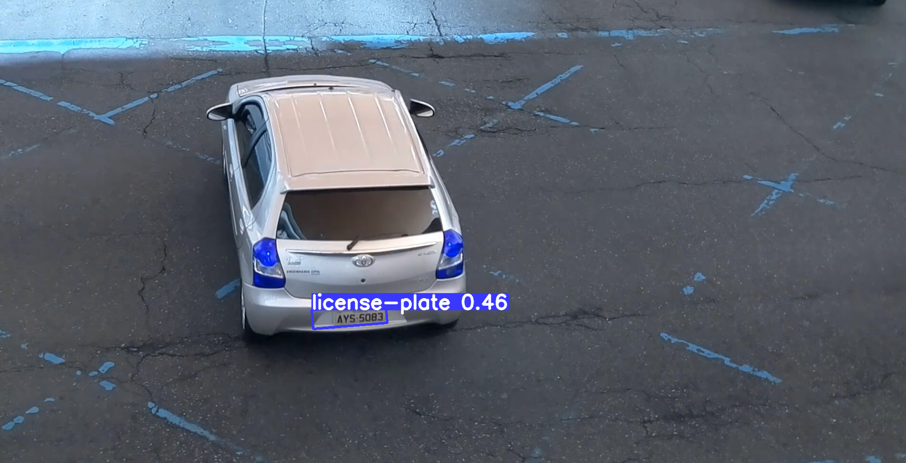

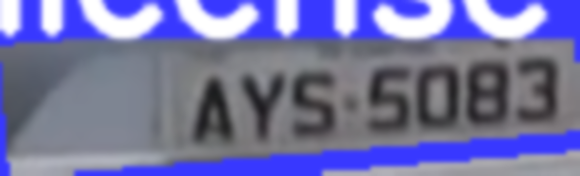

In [8]:
results = license_plate_detection('./illustrations/illustration_image.png')
cropped_image = None
upscaled_image = None
downscaled_image = None

for r in results:
    im_array = r.plot()
    img = PILImage.fromarray(im_array)
    width, height = img.size
    resize_factor = 0.5 
    img_resized = img.resize((int(width * resize_factor), int(height * resize_factor)))
    display(img_resized)
    
    for k in r.obb:
        if k.cls == 0:
            cropped_image = Utils.crop_image_license(utils, im_array, k.xyxyxyxy)
            
            # upscaling the image using gaussian pyramid in order to make the features easier to detect later
            upscaled_image = ImageEnhancing.upscale_gaussian_pyramid(image_enhancing, cropped_image, 3)
            upscaled_width, upscaled_height = upscaled_image.shape[1], upscaled_image.shape[0]
            
            # downscaling for displaying 
            downscale_factor = 0.5
            downscaled_image = PILImage.fromarray(upscaled_image).resize(
                (int(upscaled_width * downscale_factor), int(upscaled_height * downscale_factor))
            )
            display(downscaled_image)

### Character detection

In [9]:
detected_chars = utils.detect_characters(character_detection, PILImage.fromarray(upscaled_image), conf=0.7, spacing_threshold=70)
detected_text = ''.join(detected_chars) 
print("Detected text: " + detected_text)


0: 96x256 105.8ms
Speed: 1.0ms preprocess, 105.8ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 256)
Detected text: YS508


### Denoising


0: 96x256 85.1ms
Speed: 23.6ms preprocess, 85.1ms inference, 27.0ms postprocess per image at shape (1, 3, 96, 256)
Detected text: AYS5083


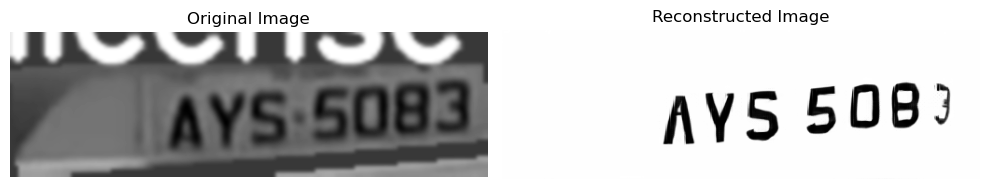

In [10]:
upscaled_image_pil = PILImage.fromarray(upscaled_image).convert('L')

device = torch.device("cpu")
model = UNet().to(device)

checkpoint = torch.load(license_plate_denoising, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

transform = transforms.Compose([
    transforms.Resize((160, 512)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

input_tensor = transform(upscaled_image_pil).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output_tensor = model(input_tensor)

output_image_pil = transforms.ToPILImage()(output_tensor.squeeze().cpu())

detected_chars = utils.detect_characters(character_detection, output_image_pil, conf=0.7, spacing_threshold=70)
detected_text = ''.join(detected_chars) 
print("Detected text: " + detected_text)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

axes[0].imshow(upscaled_image_pil, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off') 

axes[1].imshow(output_image_pil, cmap='gray')
axes[1].set_title("Reconstructed Image")
axes[1].axis('off')  

plt.tight_layout() 
plt.show()

Note that when using the character detection model on the denoised image, with the same confidence threshold as before (0.7), it is now able to detect the entire text.

## config

In [11]:
font_scale = 2
font_color = (0, 255, 0)
thickness = 3
line_type = cv2.LINE_AA
text_height_offset = 50
font = cv2.FONT_HERSHEY_SIMPLEX
VIDEO_PATH_1 = './all_datasets/dataset_4_videos/Video1.mp4'
VIDEO_PATH_2 = './all_datasets/dataset_4_videos/Video2.mp4'
TEXT_FILE_PATH = 'detected_texts.txt'

# Baseline experiment

In [10]:
cap = cv2.VideoCapture(VIDEO_PATH_2)
text_base_position = None
detected_texts = []

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Finished playing video.")
        break 

    detected_texts.clear()
    results = license_plate_detection(frame)
    annotated_frame = frame.copy()

    # Detects license plates (Tensor with class 0)
    for r in results:
        for k in r.obb:
            if k.cls == 0:
                cropped_image = utils.crop_image_license(frame, k.xyxyxyxy)
                
                # Character detection
                detected_chars = utils.detect_characters(character_detection, PILImage.fromarray(cropped_image), conf=0.7, spacing_threshold=70)
                detected_text = ''.join(detected_chars)  
                detected_texts.append(detected_text)

                # Writes detected characters to file
                with open(TEXT_FILE_PATH, 'a') as file:
                    file.write(detected_text + '\n')

                # Shows detected characters on the frame for illustration
                frame_height, frame_width = frame.shape[:2]
                for i, text in enumerate(detected_texts):
                    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
                    text_x = int((frame_width - text_size[0]) / 2)
                    text_y = frame_height - text_height_offset - (i * (text_size[1] + 10))
                    cv2.putText(annotated_frame, text, (text_x, text_y), font, font_scale, font_color, thickness, line_type)
            cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
            cv2.resizeWindow('Video', 960, 540)
            cv2.imshow('Video', annotated_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            continue  
        break 
    else:
        continue  
    break  

cap.release()
cv2.destroyAllWindows()


0: 736x1280 222.2ms
Speed: 28.2ms preprocess, 222.2ms inference, 31.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 15.9ms
Speed: 0.0ms preprocess, 15.9ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 0.0ms
Speed: 15.6ms preprocess, 0.0ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 0.0ms
Speed: 0.0ms preprocess, 0.0ms inference, 15.6ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 (no detections), 16.4ms
Speed: 0.0ms preprocess, 16.4ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 15.5ms
Speed: 0.0ms preprocess, 15.5ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 128x256 117.4ms
Speed: 0.0ms preprocess, 117.4ms inference, 9.5ms postprocess per image at shape (1, 3, 128, 256)

0: 736x1280 10.7ms
Speed: 10.0ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 10.0ms
Speed: 9.5ms preprocess, 1

Results for the baseline:

In [2]:
comparer = ModelComparer('./all_datasets/dataset_4_videos/ground_truths/Video2.txt')
comparer.compare('./experiments/baseline/baseline_video_2.txt')
print(comparer.compare_to_gt())

0.25925925925925924


# Experiment: 1

In [12]:
cap = cv2.VideoCapture(VIDEO_PATH_1)
text_base_position = None
detected_texts = []

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Finished playing video.")
        break 

    detected_texts.clear()
    results = license_plate_detection(frame)
    annotated_frame = frame.copy()

    # Detects license plates (Tensor with class 0)
    for r in results:
        for k in r.obb:
            if k.cls == 0:
                # Image adjustments below this line
                
                cropped_image = utils.crop_image_license(frame, k.xyxyxyxy)
                upscaled_image = image_enhancing.upscale_gaussian_pyramid(cropped_image, 3)
                enhanced_text_image = image_enhancing.increase_contrast(upscaled_image)
                
                # Image adjustments above this line

                # Character detection
                detected_chars = utils.detect_characters(character_detection, PILImage.fromarray(enhanced_text_image), conf=0.7, spacing_threshold=70)
                detected_text = ''.join(detected_chars)  
                detected_texts.append(detected_text)

                # Writes detected characters to file
                with open(TEXT_FILE_PATH, 'a') as file:
                    file.write(detected_text + '\n')

                # Shows detected characters on the frame for illustration
                frame_height, frame_width = frame.shape[:2]
                for i, text in enumerate(detected_texts):
                    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
                    text_x = int((frame_width - text_size[0]) / 2)
                    text_y = frame_height - text_height_offset - (i * (text_size[1] + 10))
                    cv2.putText(annotated_frame, text, (text_x, text_y), font, font_scale, font_color, thickness, line_type)
            cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
            cv2.resizeWindow('Video', 960, 540)
            cv2.imshow('Video', annotated_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            continue  
        break 
    else:
        continue  
    break  

cap.release()
cv2.destroyAllWindows()


0: 736x1280 215.1ms
Speed: 20.8ms preprocess, 215.1ms inference, 44.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 150.5ms
Speed: 3.0ms preprocess, 150.5ms inference, 15.3ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 (no detections), 133.5ms
Speed: 7.0ms preprocess, 133.5ms inference, 6.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 39.2ms
Speed: 9.1ms preprocess, 39.2ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 14.4ms
Speed: 0.0ms preprocess, 14.4ms inference, 2.0ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 6.3ms
Speed: 7.6ms preprocess, 6.3ms inference, 5.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 10.4ms
Speed: 1.3ms preprocess, 10.4ms inference, 2.9ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 6.0ms
Speed: 6.0ms preprocess, 6.0ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 13.9ms
Speed: 1.0ms preprocess, 13.

Results for experiment 1:

In [2]:
comparer = ModelComparer('./all_datasets/dataset_4_videos/ground_truths/Video1.txt')
comparer.compare('./experiments/1/1_video_1.txt')
print(comparer.compare_to_gt())

0.3333333333333333


# Experiment: 2 - Easy OCR detection

In [12]:
reader = easyocr.Reader(['en'])

cap = cv2.VideoCapture(VIDEO_PATH_2)
text_base_position = None
detected_texts = []

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Finished playing video.")
        break 

    detected_texts.clear()
    results = license_plate_detection(frame)
    annotated_frame = frame.copy()

    # Detects license plates (Tensor with class 0)
    for r in results:
        for k in r.obb:
            if k.cls == 0:
                # Image adjustments below this line
                
                cropped_image = utils.crop_image_license(frame, k.xyxyxyxy)
                upscaled_image = image_enhancing.upscale_gaussian_pyramid(cropped_image, 3)
                enhanced_text_image = image_enhancing.increase_contrast(upscaled_image)
                
                # Image adjustments above this line
                
                # Using EasyOCR to detect characters
                pil_image = PILImage.fromarray(enhanced_text_image)
                ocr_result = reader.readtext(np.array(pil_image), paragraph="False")
                detected_text = ' '.join([text[1] for text in ocr_result])
                detected_text_upper = detected_text.upper()
                detected_texts.append(detected_text_upper)
                # Writes detected characters to file
                with open(TEXT_FILE_PATH, 'a') as file:
                    file.write(detected_text_upper + '\n')

                # Shows detected characters on the frame for illustration
                frame_height, frame_width = frame.shape[:2]
                for i, text in enumerate(detected_texts):
                    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
                    text_x = int((frame_width - text_size[0]) / 2)
                    text_y = frame_height - text_height_offset - (i * (text_size[1] + 10))
                    cv2.putText(annotated_frame, text, (text_x, text_y), font, font_scale, font_color, thickness, line_type)
            cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
            cv2.resizeWindow('Video', 960, 540)
            cv2.imshow('Video', annotated_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            continue  
        break 
    else:
        continue  
    break  

cap.release()
cv2.destroyAllWindows()


0: 736x1280 208.0ms
Speed: 22.6ms preprocess, 208.0ms inference, 9.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 8.0ms
Speed: 6.0ms preprocess, 8.0ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.5ms
Speed: 9.9ms preprocess, 12.5ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 7.8ms
Speed: 10.4ms preprocess, 7.8ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 14.4ms
Speed: 6.5ms preprocess, 14.4ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 10.1ms
Speed: 5.0ms preprocess, 10.1ms inference, 4.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 8.0ms
Speed: 6.5ms preprocess, 8.0ms inference, 4.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 10.1ms
Speed: 8.3ms preprocess, 10.1ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 7.8ms
Speed: 6.4ms preproces

Results for experiment 2:

In [2]:
comparer = ModelComparer('./all_datasets/dataset_4_videos/ground_truths/Video2.txt')
comparer.compare('./experiments/2/2_video_2.txt')
print(comparer.compare_to_gt())

0.1111111111111111


# Experiment: 3

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet().to(device)
checkpoint = torch.load(license_plate_denoising, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

transform = transforms.Compose([
    transforms.Resize((160, 512)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

cap = cv2.VideoCapture(VIDEO_PATH_2)
detected_texts = []

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Finished playing video.")
        break 

    detected_texts.clear()
    results = license_plate_detection(frame)
    annotated_frame = frame.copy()

    # Detects license plates (Tensor with class 0)
    for r in results:
        for k in r.obb:
            if k.cls == 0:
                
                # Image adjustments below this line
                
                cropped_image = utils.crop_image_license(frame, k.xyxyxyxy)
                upscaled_image = image_enhancing.upscale_gaussian_pyramid(cropped_image, 2)
                upscaled_image_pil = PILImage.fromarray(upscaled_image).convert('L')
                input_tensor = transform(upscaled_image_pil).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    output_tensor = model(input_tensor)
                enhanced_text_image = transforms.ToPILImage()(output_tensor.squeeze().cpu())
                
                # Image adjustments above this line
                
                detected_chars = utils.detect_characters(character_detection, enhanced_text_image, conf=0.7, spacing_threshold=70)
                detected_text = ''.join(detected_chars)  
                detected_texts.append(detected_text)

                with open(TEXT_FILE_PATH, 'a') as file:
                    file.write(detected_text + '\n')

                frame_height, frame_width = frame.shape[:2]
                text_size = cv2.getTextSize(detected_text, font, font_scale, thickness)[0]
                text_x = int((frame_width - text_size[0]) / 2)
                text_y = frame_height - text_height_offset - (len(detected_texts) * (text_size[1] + 10))
                cv2.putText(annotated_frame, detected_text, (text_x, text_y), font, font_scale, font_color, thickness, line_type)

    cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
    cv2.resizeWindow('Video', 960, 540)
    cv2.imshow('Video', annotated_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break 

cap.release()
cv2.destroyAllWindows()



0: 736x1280 8.6ms
Speed: 6.1ms preprocess, 8.6ms inference, 5.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 11.2ms
Speed: 0.0ms preprocess, 11.2ms inference, 2.3ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 9.4ms
Speed: 8.2ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 (no detections), 9.4ms
Speed: 6.0ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 9.3ms
Speed: 5.4ms preprocess, 9.3ms inference, 2.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 11.5ms
Speed: 1.0ms preprocess, 11.5ms inference, 0.0ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 8.6ms
Speed: 4.3ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 17.0ms
Speed: 1.0ms preprocess, 17.0ms inference, 3.

Results for experiment 3:

In [2]:
comparer = ModelComparer('./all_datasets/dataset_4_videos/ground_truths/Video2.txt')
comparer.compare('./experiments/3/3_video_2.txt')
print(comparer.compare_to_gt())

0.3333333333333333


# Experiment: 4 - Adaptive Thresholding

In [11]:
cap = cv2.VideoCapture(VIDEO_PATH_2)
text_base_position = None
detected_texts = []

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        print("Finished playing video.")
        break 

    detected_texts.clear()
    results = license_plate_detection(frame)
    annotated_frame = frame.copy()

    # Detects license plates (Tensor with class 0)
    for r in results:
        for k in r.obb:
            if k.cls == 0:
                # Image adjustments below this line
                
                cropped_image = utils.crop_image_license(frame, k.xyxyxyxy)
                enhanced_text_image = image_enhancing.apply_adaptive_thresholding(cropped_image)
                
                # Image adjustments above this line

                # Character detection
                detected_chars = utils.detect_characters(character_detection, PILImage.fromarray(enhanced_text_image), conf=0.7, spacing_threshold=70)
                detected_text = ''.join(detected_chars)  
                detected_texts.append(detected_text)

                # Writes detected characters to file
                with open(TEXT_FILE_PATH, 'a') as file:
                    file.write(detected_text + '\n')

                # Shows detected characters on the frame for illustration
                frame_height, frame_width = frame.shape[:2]
                for i, text in enumerate(detected_texts):
                    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
                    text_x = int((frame_width - text_size[0]) / 2)
                    text_y = frame_height - text_height_offset - (i * (text_size[1] + 10))
                    cv2.putText(annotated_frame, text, (text_x, text_y), font, font_scale, font_color, thickness, line_type)
            cv2.namedWindow('Video', cv2.WINDOW_NORMAL)
            cv2.resizeWindow('Video', 960, 540)
            cv2.imshow('Video', annotated_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            continue  
        break 
    else:
        continue  
    break  

cap.release()
cv2.destroyAllWindows()


0: 736x1280 230.1ms
Speed: 10.4ms preprocess, 230.1ms inference, 13.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 10.7ms
Speed: 0.1ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 7.2ms
Speed: 6.0ms preprocess, 7.2ms inference, 4.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 9.9ms
Speed: 0.0ms preprocess, 9.9ms inference, 2.8ms postprocess per image at shape (1, 3, 96, 256)

0: 736x1280 (no detections), 6.7ms
Speed: 6.7ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 6.9ms
Speed: 5.0ms preprocess, 6.9ms inference, 3.0ms postprocess per image at shape (1, 3, 736, 1280)

0: 128x256 10.9ms
Speed: 0.0ms preprocess, 10.9ms inference, 2.0ms postprocess per image at shape (1, 3, 128, 256)

0: 736x1280 6.0ms
Speed: 5.7ms preprocess, 6.0ms inference, 3.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 96x256 9.9ms
Speed: 1.0ms preprocess, 9.9ms inferen

Results for experiment 4:

In [2]:
comparer = ModelComparer('./all_datasets/dataset_4_videos/ground_truths/Video2.txt')
comparer.compare('./experiments/4/4_video_2.txt')
print(comparer.compare_to_gt())

0.4074074074074074
